# Estimate of Public Jupyter Notebooks on GitHub

This notebook shows the historical count and future estimate of the number of `*.ipynb` files on GitHub. The daily count comes from executing the query [extension:ipynb nbformat_minor](https://github.com/search?utf8=%E2%9C%93&q=extension%3Aipynb+nbformat_minor).

## Data Collection

* Late-2014 to mid-2016: I wrote a script that scrapes the GitHub web search UI for the count, appends to a CSV, executes a notebook, and stores the results in a gist at https://gist.github.com/parente/facb555dfbae28e817e0. I scheduled the script to run daily.
* Mid-2106 to late-2016: The GitHub web search UI started requiring authentication to see global search results. I stopped collecting data.
* Late-2016 to early-2019: I rewrote the process to include a human-in-the-loop who entered the hit count after viewing the search results page. I moved the CSV, notebook, and scripts to this repo, and sporadically ran the script.
* Early-2019: I found out that the GitHub search API now supports global search by file type. I automated the entire collection process again and set it to run on TravisCI on a daily schedule.

## Assumptions

1. That the search query hits and notebooks on GitHub are in 1:1 correspondence.
1. That GitHub is accurately reporting the total number of `*.ipynb` file hits.
1. That the result is **not** inflated due to GitHub forks.
    * Evidence: We do not see the tutorial notebooks from the ipython/ipython GitHub repository duplicated in the search results because of the 2,000+ forks of the ipython/ipython repo.
1. That the result **is** inflated a tiny bit by manually created duplicates of notebooks.
    * Evidence: Some people seem to download their favorite notebooks and then upload them into their own git repositories for safe keeping.

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
%matplotlib inline

In [3]:
import datetime
import fbprophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

Importing plotly failed. Interactive plots will not work.


In [4]:
mpl.style.use('ggplot')
figsize = (14,7)

In [5]:
now = datetime.datetime.utcnow()
print(f'This notebook was last rendered at {now} UTC')

This notebook was last rendered at 2020-04-16 02:03:56.387490 UTC


## Raw Hits

First, let's load the historical data into a DataFrame indexed by date.

In [6]:
hits_df = pd.read_csv('ipynb_counts.csv', index_col=0, header=0, parse_dates=True)
hits_df.reset_index(inplace=True)
hits_df.drop_duplicates(subset='date', inplace=True)
hits_df.set_index('date', inplace=True)
hits_df.sort_index(ascending=True, inplace=True)

In [7]:
hits_df.tail(3)

,hits
date,
2020-04-14,7139729
2020-04-15,7160233
2020-04-16,7160550


There might be missing counts for days that we failed to sample. We build up the expected date range and insert NaNs for dates we missed.

In [8]:
til_today = pd.date_range(hits_df.index[0], hits_df.index[-1])

In [9]:
hits_df = hits_df.reindex(til_today)

Now we plot the known notebook counts.

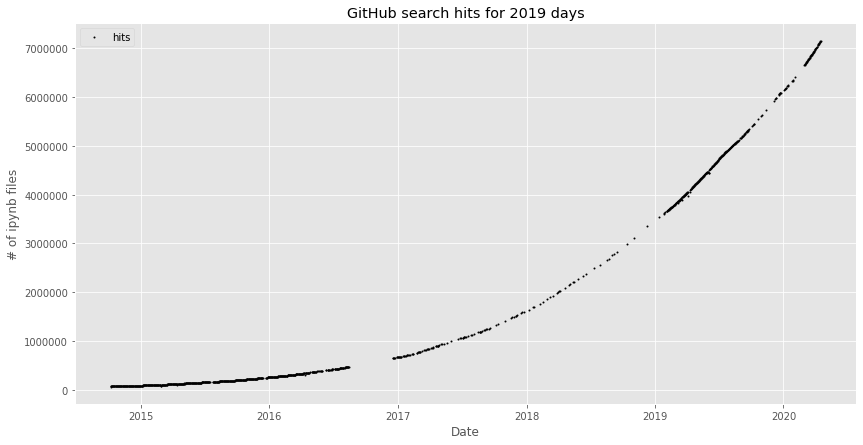

In [10]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'GitHub search hits for {len(hits_df)} days')
ax.plot(hits_df.hits, 'ko', markersize=1, label='hits')
ax.legend(loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('# of ipynb files');

## Change

Next, let's look at various measurements of change.

The total change in the number of `*.ipynb` hits between the first day we have data and today is:

In [11]:
total_delta_nbs = hits_df.iloc[-1] - hits_df.iloc[0]
total_delta_nbs

hits    7094702.0
dtype: float64

The mean daily change for the entire duration is:

In [12]:
avg_delta_nbs = total_delta_nbs / len(hits_df)
avg_delta_nbs

hits    3513.968301
dtype: float64

The change in hit count between any two consecutive days for which we have data looks like the following:

In [13]:
daily_deltas = (hits_df.hits - hits_df.hits.shift())

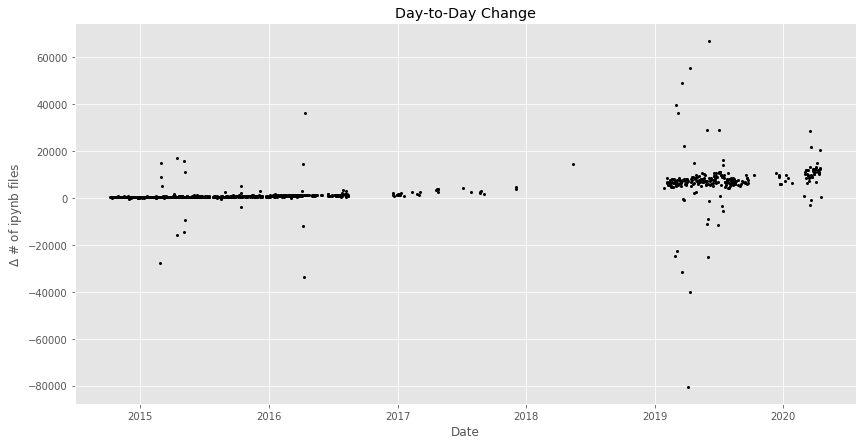

In [14]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(daily_deltas, 'ko', markersize=2)
ax.set_xlabel('Date')
ax.set_ylabel('$\Delta$ # of ipynb files')
ax.set_title('Day-to-Day Change');

The large jumps in the data are from GitHub reporting drastically different counts from one day to the next. Maybe GitHub was rebuilding a search index when we queried or had a search broker out-of-sync with the others?

Let's drop outliers defined as values more than two standard deviations away from a centered 180 day rolling mean.

In [15]:
daily_delta_rolling = daily_deltas.rolling(window=90, min_periods=0, center=True)
outliers = abs(daily_deltas - daily_delta_rolling.mean()) > 1.5*daily_delta_rolling.std()
outliers.value_counts()

False    1955
True       64
Name: hits, dtype: int64

In [16]:
cleaned_hits_df = hits_df.copy()
cleaned_hits_df[outliers] = np.NaN
cleaned_daily_deltas = (cleaned_hits_df.hits - cleaned_hits_df.hits.shift())

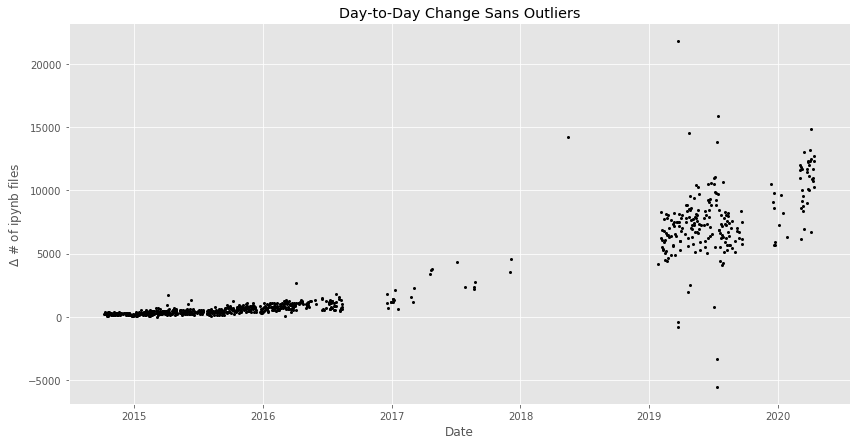

In [17]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(cleaned_daily_deltas, 'ko', markersize=2)
ax.set_xlabel('Date')
ax.set_ylabel('$\Delta$ # of ipynb files')
ax.set_title('Day-to-Day Change Sans Outliers');

Now let's do a simple linear interpolation for missing values and then look at the rolling mean of change.

In [18]:
filled_df = cleaned_hits_df.interpolate(method='time')
smoothed_daily_deltas = (filled_df.hits - filled_df.hits.shift()).rolling(window=30, min_periods=0, center=False).mean()

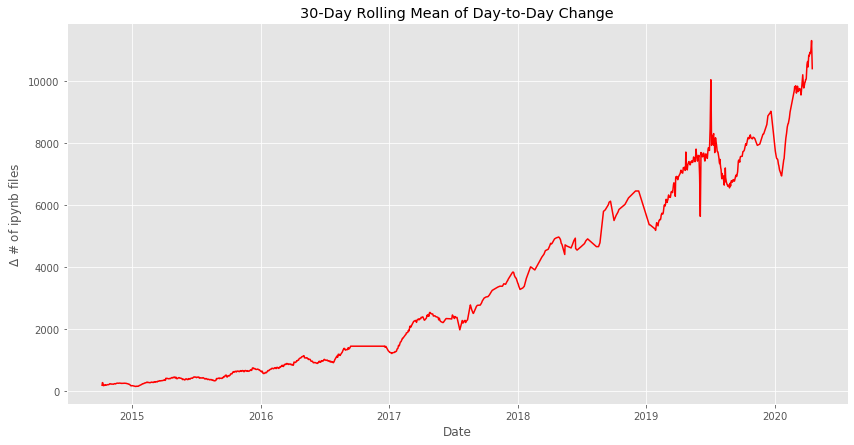

In [19]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(smoothed_daily_deltas, 'r-')
ax.set_xlabel('Date')
ax.set_ylabel('$\Delta$ # of ipynb files')
ax.set_title('30-Day Rolling Mean of Day-to-Day Change');

## Prediction

Now let's use [fbprophet](https://facebook.github.io/prophet/) to forecast growth for the upcoming year. First, we'll try to forecast based on the raw search hit data with outliers removed.

In [20]:
periods = 365

In [21]:
def forecast(df):
    # 95% confidence intervals
    m = fbprophet.Prophet(interval_width=0.95, seasonality_mode='multiplicative')
    df = df.reset_index().rename(columns={'index': 'ds', 'hits': 'y'})
    m.fit(df)
    future = m.make_future_dataframe(periods=periods)
    return m, m.predict(future)

In [22]:
model, forecast_df = forecast(cleaned_hits_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
def plot_forecast(m, fc):
    fig, ax = plt.subplots(figsize=figsize)
    m.plot(fc, ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('# ipynb files')
    ax.minorticks_on()
    ax.legend(loc='upper left')
    ax.set_title(f'GitHub search hits predicted until {fc.iloc[-1].ds.date()} (95% confidence interval)')

The model appears to favor seasonality effects in the early data and replicate them throughout the forecast period. The density of early data versus the sparsity of later data is a likely cause.

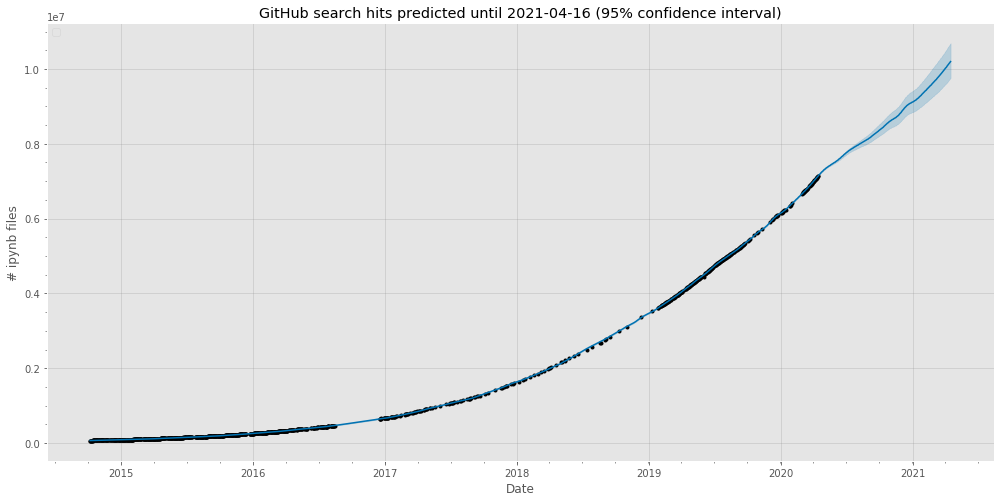

In [24]:
plot_forecast(model, forecast_df)

Let's fit and predict again, but this time on the interpolated data so that there's better balance between early and later observations.

In [25]:
model_filled, forecast_filled_df = forecast(filled_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


This forecast looks much more sensible with respect to the true measurements and overall trend.

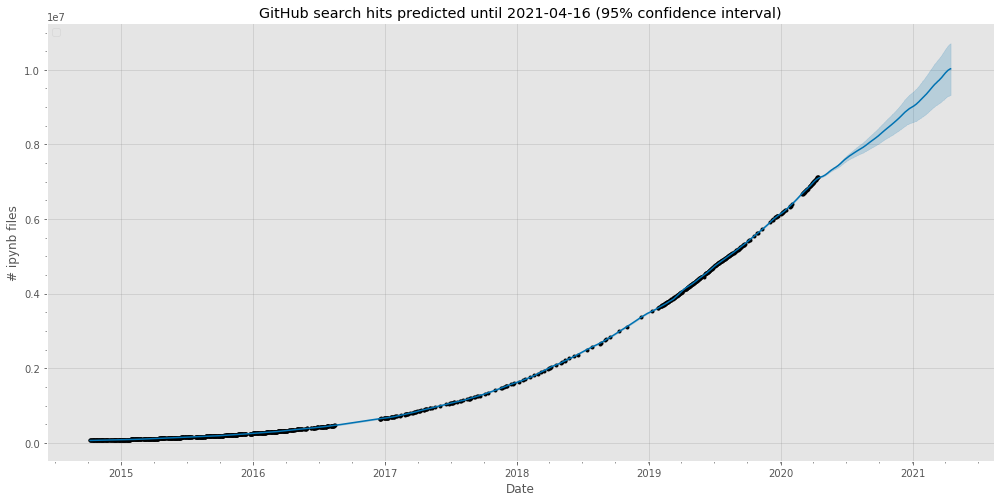

In [26]:
# Note: Using model instead of model_filled to see observations without imputed missing values
plot_forecast(model, forecast_filled_df)

Now we can plot the components of the model. The weekly component appears to track the work week while the yearly component seems to track with a traditional academic year in the northern hemisphere.

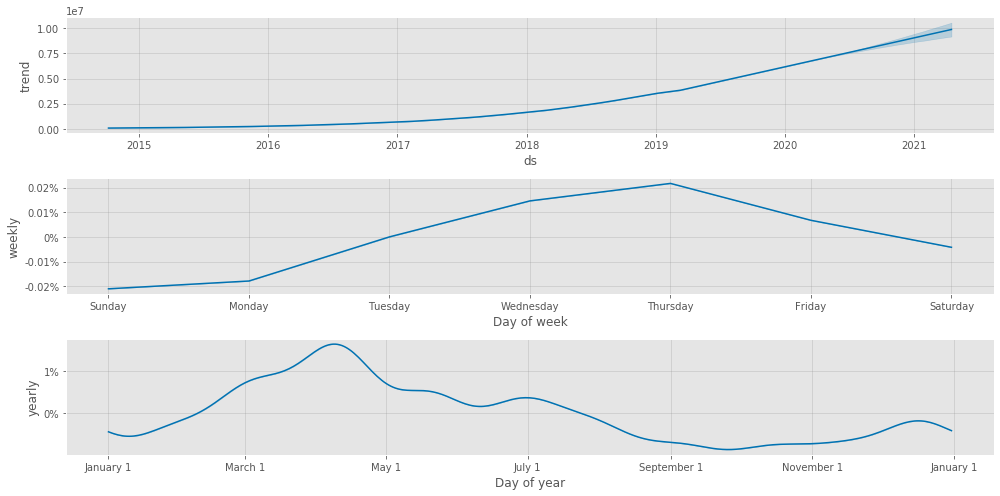

In [27]:
cv_df = fbprophet.plot.plot_components(model_filled, forecast_filled_df, figsize=figsize,)

We'll use Prophet's cross validation function to measure the root mean square error for forecasts overlapping with past data.

In [28]:
cv_df = fbprophet.diagnostics.cross_validation(model_filled, horizon='365 days', initial='730 days', period='90 days')

INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-29 00:00:00 and 2019-04-17 00:00:00


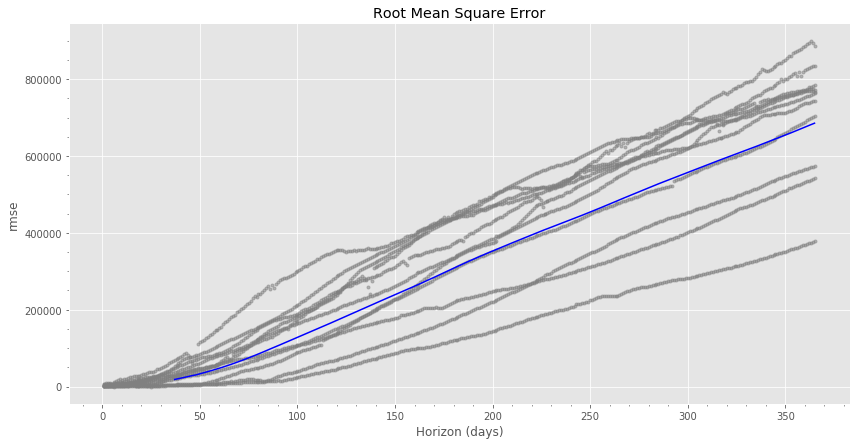

In [29]:
fig, ax = plt.subplots(figsize=figsize)
fbprophet.plot.plot_cross_validation_metric(cv_df, metric='rmse', ax=ax)
ax.set_title('Root Mean Square Error')
ax.minorticks_on();

## Milestones

Finally, it's nice to celebrate million-notebook milestones. We can use our model to predict when they're going to occur.

In [30]:
combined_df = pd.concat([filled_df.reset_index(drop=True).rename(columns={'hits': 'y'}), forecast_filled_df], axis=1)

In [31]:
rows = []
cols = {'y': 'actual', 'yhat_upper': 'optimistic', 'yhat': 'predicted', 'yhat_lower': 'conservative'}
for i in range(1, 11):
    milestone = i * 1e6
    row = {'milestone': milestone}

    for col in cols:
        gt_df = combined_df[combined_df[col] > milestone]
        if len(gt_df):
            row[col] = gt_df.iloc[0].ds
    rows.append(row)

In [32]:
pd.DataFrame(rows, columns=['milestone']+list(cols.keys())).rename(columns=cols)

,milestone,actual,optimistic,predicted,conservative
0,1000000.0,2017-06-06,2017-05-31,2017-06-05,2017-06-11
1,2000000.0,2018-04-01,2018-03-28,2018-03-30,2018-04-01
2,3000000.0,2018-10-14,2018-10-12,2018-10-14,2018-10-16
3,4000000.0,2019-03-27,2019-03-26,2019-03-27,2019-03-28
4,5000000.0,2019-08-09,2019-08-08,2019-08-09,2019-08-11
5,6000000.0,2019-12-13,2019-12-12,2019-12-13,2019-12-15
6,7000000.0,2020-04-02,2020-04-02,2020-04-03,2020-04-04
7,8000000.0,NaT,2020-08-09,2020-08-28,2020-09-24
8,9000000.0,NaT,2020-11-24,2020-12-30,2021-02-28
9,10000000.0,NaT,2021-02-20,2021-04-12,NaT
